In [23]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
n_epochs = 200
batch_size = 64
lr = 2e-4
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 1000
img_size = 32
channels = 1
sample_interval = 400

In [3]:
device = torch.device(f'cuda:0')

In [10]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [11]:
# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [32]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

NameError: name 'patch_size' is not defined

In [27]:
valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

In [29]:
valid.shape

torch.Size([64, 1])

In [30]:
xhat = discriminator(real_imgs)

In [31]:
xhat.shape

torch.Size([64, 1])

In [26]:
Tensor = torch.cuda.FloatTensor

# ----------
#  Training
# ----------

with tqdm(total=n_epochs) as pbar:    
    pbar_dict = {
        'G_disrcrim_loss': np.finfo(np.float32).max,
        'D_disrcrim_loss': np.finfo(np.float32).max,
    }

    for epoch in range(n_epochs):
        for i, (imgs, _) in enumerate(dataloader):

            # Adversarial ground truths
#             valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
#             fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            valid = torch.ones_like(imgs, requires_grad=False).to(device)
            fake = torch.zeros_like(imgs, requires_grad=False).to(device)

            # Configure input
            real_imgs = Variable(imgs.type(Tensor))

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

            # Generate a batch of images
            gen_imgs = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            pbar_dict['G_disrcrim_loss'] = g_loss.item()
            pbar_dict['D_disrcrim_loss'] = d_loss.item()

        pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(1)

  0%|                                                                                                                               | 0/200 [00:00<?, ?it/s]


ValueError: Using a target size (torch.Size([64, 1, 32, 32])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.

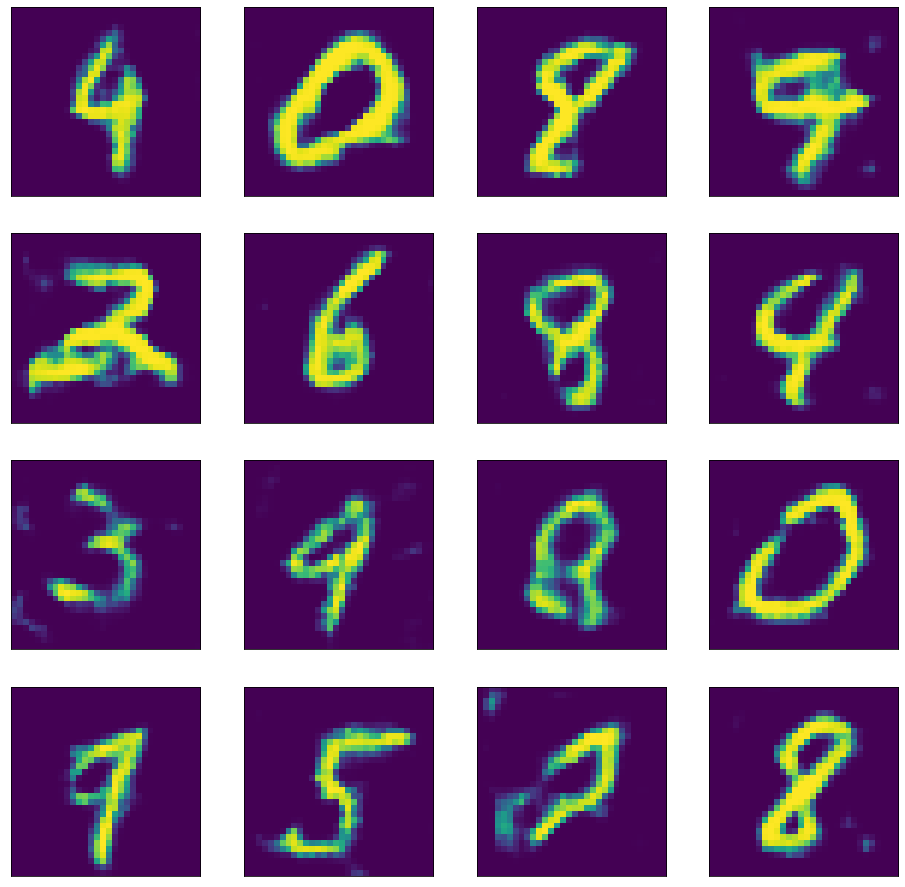

In [24]:
# visualize 16 samples
z = torch.randn((16, latent_dim), device=device)
samples = generator(z).detach().cpu().numpy()

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, ax in enumerate(axs.flat):
    ax.imshow(samples.squeeze()[i])
    ax.set_xticks([])
    ax.set_yticks([])